<a href="https://colab.research.google.com/github/jhsung7/flightProj/blob/main/1.Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Load and view dataset

In [ ]:
df = pd.read_csv("../flights_sample_3m.csv", encoding="utf-8")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.shape

(1183238, 32)

In [ ]:
df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [ ]:
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


Convert FL_DATE to "datetime" recognized by pandas

In [ ]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d').copy()

Toggle assertions on or off

In [ ]:
TEST: bool = True

Drop cancelled and diverted flights, they are outside of our scope. we only want delayed flights

In [ ]:
num_cancelled_or_diverted = len(df[(df['CANCELLED'] == 1) | (df['DIVERTED'] == 1)])
cancelled_or_diverted_counts = df[(df['CANCELLED'] == 1) | (df['DIVERTED'] == 1)]["FL_DATE"].dt.strftime('%Y-%m').value_counts().sort_index()
df = df[(df['CANCELLED'] != 1) & (df['DIVERTED'] != 1)]

Attempt to drop duplicates, we found out there aren't any

In [ ]:
df_len_with_duplicates = len(df)
df.drop_duplicates(inplace=True)
if TEST:
  assert len(df) == df_len_with_duplicates  # no duplicates

In [ ]:
def split_by_components(df: pd.DataFrame):
  # Finding: if there is one component, it has all components
  isna_mask = df[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
                  'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                  'DELAY_DUE_LATE_AIRCRAFT']].isna().any(axis=1)

  delay_components_df = df[~isna_mask]
  no_delay_components_df = df[isna_mask]

  return delay_components_df, no_delay_components_df


Visualize presence of delay components

In [ ]:
delay_components_df, no_delay_components_df = split_by_components(df)

ratio_components = len(delay_components_df) / len(df)

fig = px.pie(values=[len(delay_components_df), len(no_delay_components_df), num_cancelled_or_diverted],
             names=["Has delay components", "Missing delay components", "Cancelled or Diverted"])
fig.update_layout(title_text="Y Delay Components", title_x=0.5, width=800, height=600)

Visualize presence of delay components over each month in the dataset. Blue represents data that we can use.

In [ ]:
components_counts = delay_components_df["FL_DATE"].dt.strftime('%Y-%m').value_counts().sort_index()
no_components_counts = no_delay_components_df["FL_DATE"].dt.strftime('%Y-%m').value_counts().sort_index()
all_dates = pd.concat([components_counts, no_components_counts, cancelled_or_diverted_counts], axis=1, keys=['Components', 'No Components', "Cancelled or Diverted"])

# Reset index to convert index (dates) to a column
all_dates.reset_index(inplace=True)
all_dates.columns = ['Date', 'Has Delay Components', 'Missing Delay Components', "Cancelled or Diverted"]

# Plotting the histogram using Plotly Express
fig = px.histogram(all_dates, x='Date', y=['Has Delay Components', 'Missing Delay Components', "Cancelled or Diverted"], barmode='stack',
                   labels={'Date': 'Unique Dates', 'value': 'Count', 'variable': 'Delay Status'})
fig.update_xaxes(type='category')  # Set x-axis type to category for better organization
# fig.update_layout(title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=20
    ),
    width=1200
)
fig.show()

Ensure that delay components always sum to equal arrival delay

In [ ]:
if TEST:
  def check_delay_components_sum_to_arr_delay(row) -> bool:
      components_delay = row[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER',
                            'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
                            'DELAY_DUE_LATE_AIRCRAFT']].sum()
      return components_delay == row['ARR_DELAY']

  assert delay_components_df.apply(check_delay_components_sum_to_arr_delay, axis=1).all()

Set data to just the delay components to simplify referencing below

In [ ]:
data = delay_components_df.copy()

Remove outliers using IQR method on the overall arrival delay

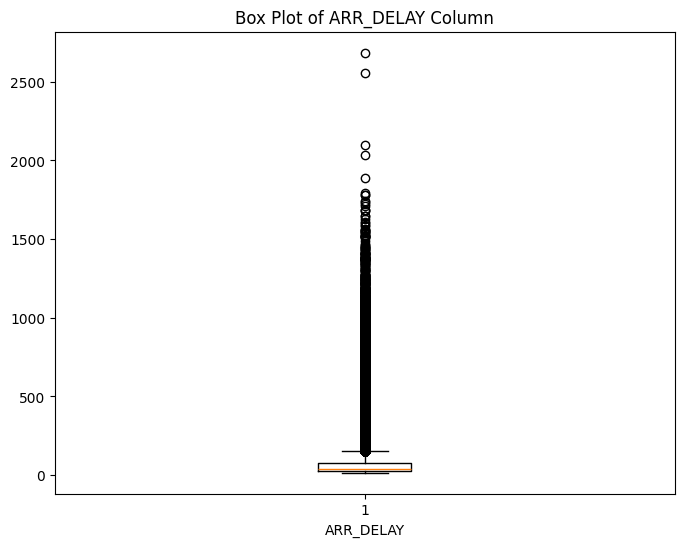

Summary Statistics after Removing Outliers:
count    193974.000000
mean         47.982596
std          33.095441
min          15.000000
25%          23.000000
50%          36.000000
75%          64.000000
max         155.000000
Name: ARR_DELAY, dtype: float64
count    210990.000000
mean         67.371463
std          93.202190
min          15.000000
25%          23.000000
50%          39.000000
75%          76.000000
max        2685.000000
Name: ARR_DELAY, dtype: float64
0.08064837196075643
17016


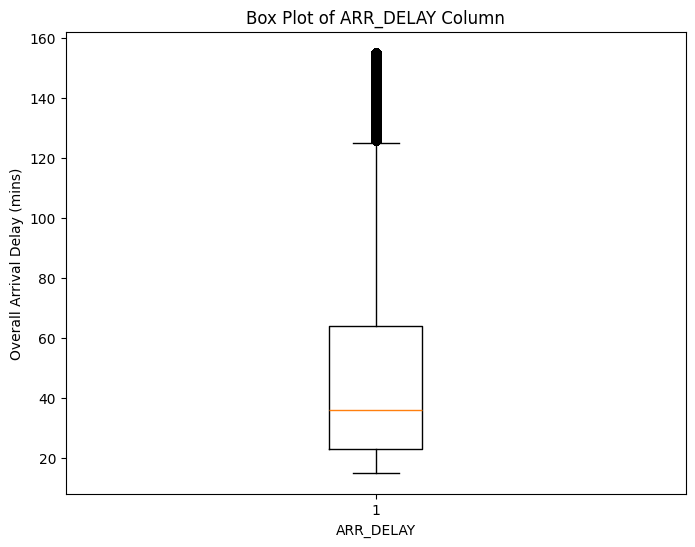

In [ ]:
# Boxplot before removing outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data['ARR_DELAY'])
plt.title('Box Plot of ARR_DELAY Column')
plt.xlabel('ARR_DELAY')
plt.show()

# Calculate Q1, Q3, IQR
Q1 = data['ARR_DELAY'].quantile(0.25)
Q3 = data['ARR_DELAY'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data_no_outliers = data[(data['ARR_DELAY'] >= lower_bound) & (data['ARR_DELAY'] <= upper_bound)]

print("Summary Statistics after Removing Outliers:")
print(data_no_outliers['ARR_DELAY'].describe())
print(data["ARR_DELAY"].describe())

print((len(data) - len(data_no_outliers)) / len(data))
print((len(data) - len(data_no_outliers)))

# Box plot after removing outliers
plt.figure(figsize=(8, 6))
plt.boxplot(data_no_outliers['ARR_DELAY'])
plt.title('Box Plot of ARR_DELAY Column')
plt.xlabel('ARR_DELAY')
plt.ylabel("Overall Arrival Delay (mins)")
plt.show()


Calculate Pearson Correlation on just the non-categorical attributes, since Pearson Correlation is invalid for categorical attributes

In [ ]:
from scipy.stats import pearsonr

def calculate_pearson_score(df: pd.DataFrame, col: str, y) -> float:
  """
  Calculates the Pearson correlation coefficient between two columns in a DataFrame.

  Args:
    df: DataFrame.
    col: The name of the first column.
    y: The name of the second column.

  Returns:
    Pearson correlation coefficient.
  """
  try:
    corr,_ = pearsonr(df[col].values, y.values)
    return corr
  except:
    return 0

# Calculate the Pearson correlation coefficient for each column w/ ARR_DELAY
pearson_scores = {}
cols=['CRS_DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
      'DISTANCE']
for col in cols:
    pearson_scores[col] = calculate_pearson_score(data_no_outliers, col, data_no_outliers["ARR_DELAY"])

# Sort the Pearson correlation coefficients
sorted_pearson_scores = sorted(pearson_scores.items(), key=lambda x: x[1], reverse=True)

for col, score in sorted_pearson_scores:
    print(f"{col}: {score}")

# NOTE: ELAPSED TIME IS REDUNDANT

CRS_DEP_TIME: 0.07159201303494427
TAXI_OUT: 0.056752081109694624
CRS_ARR_TIME: 0.050354683967986105
TAXI_IN: 0.025494098460931404
CRS_ELAPSED_TIME: -0.01101990679959589
DISTANCE: -0.021216318645845222


Calculate Kruskal-Wallis H-test to sort categorical attributes and prove redundancy for some attributes

In [ ]:
from scipy.stats import kruskal

cols = ['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
        'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY']

# Calculate the Kruskal-Wallis H statistic for each categorical variable
h_values = {}
for col in cols:
    h, p_value = kruskal(*[group['ARR_DELAY'] for name, group in data_no_outliers.groupby(col)])
    h_values[col] = h

# Sort the columns by their H values
sorted_cols = sorted(h_values, key=h_values.get, reverse=True)

print("Categorical columns ranked by their correlation with:")
for col in sorted_cols:
    print(f"{col}: {h_values[col]}")

# drop AIRLINE_DOT, AIRLINE_CODE, DOT_CODE bc redundant w/ AIRLINE
# drop ORIGIN_CITY, DEST_CITY bc redundant (basically) w/ ORIGIN, DEST

Categorical columns ranked by their correlation with:
FL_NUMBER: 7558.607201031696
FL_DATE: 5750.997967209874
AIRLINE: 1967.613867223968
AIRLINE_DOT: 1967.613867223968
AIRLINE_CODE: 1967.613867223968
DOT_CODE: 1967.613867223968
ORIGIN: 1956.3076761767882
ORIGIN_CITY: 1857.3837538824268
DEST: 1737.7405251353512
DEST_CITY: 1648.920001182146


In [ ]:
X_df = data_no_outliers[
    [
        "FL_DATE",  # yyymmdd of flight (ordinal, discrete),
        "FL_NUMBER",
        "AIRLINE",  # name of airline (nominal, discrete)
        # Ignore AIRLINE_CODE because it is redundant
        "ORIGIN",  # origin airport code (nomincal, discrete)
        # Ignore ORIGIN_CITY because it is redundant
        "DEST",  # destination airport code (nomincal, discrete)
        # Ignore DEST_CITY because it is redundant
        "CRS_DEP_TIME",  # hhmm planned departure time (ordinal, discrete)
        "CRS_ARR_TIME",  # hhmm planned arrival time (ordinal, discrete)
        # Ignore CRS_ELAPSED_TIME because it is redundant since we have CRS_DEP_TIME and CRS_ARR_TIME
        "DISTANCE",  # miles between airports (ratio, discrete)
        "TAXI_IN",
        "TAXI_OUT"
    ]
]

Y_df = data_no_outliers[
    [
        # "CANCELLATION_CODE",  # reason for cancellation, NA if not cancelled (nominal, discrete)
        # Ignore CANCELLED because it is redundant, CANCELLATION_CODE provides more information
        # "DIVERTED",  # 1 if diverted, 0 if not (ordinal, discrete) NOTE: NOT SURE IF WE WANT TO KEEP
        # "AIR_TIME",  # Flight time, minutes (ratio, discrete)
        "DELAY_DUE_CARRIER",  # delay due to technical difficulties / damage / carrier efficiency (ratio, discrete)
        # Hypothesis: AIRLINE, ORIGIN, DEST may inform DELAY_DUE_CARRIER
        "DELAY_DUE_WEATHER",  # delay due to weather (ratio, discrete)
        # Hypothesis: FL_DATE, ORIGIN, DEST may inform DELAY_DUE_WEATHER
        "DELAY_DUE_SECURITY",  # delay due to security (ratio, discrete)
        # Hypothesis: FL_DATE, ORIGIN, CRS_DEP_TIME, DISTANCE may inform DELAY_DUE_SECURITY,
        "DELAY_DUE_NAS",  # not sure how this will do due to lacking info in features
        "DELAY_DUE_LATE_AIRCRAFT"  # delay due to late aircraft (ratio, discrete)
        # Hypothesis: AIRLINE, CRS_DEP_TIME may inform DELAY_DUE_LATE_AIRCRAFT
    ]
]

arr_only_y_df = data_no_outliers["ARR_DELAY"]

# AIRLINE_CODE, DOT_CODE, FL_NUMBER are ignored because they are unique identifiers
# TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN are ignored because they seem irrelevant NOTE: MAY WANT TO LOOK INTO THIS
# DEP_TIME, DEP_DELAY, ARR_TIME, ARR_DELAY, ELAPSED_TIME are ignored because the individual delay contributions factor into them

# WARNING: DELAY_DUE_NAS might not have sufficient info to predict this. It is National Air System Delay, minutes.


Check if there are any NA values in X_df. There are none

In [ ]:
# Look for any NA values in X
if TEST:
  X_df.replace('', np.nan, inplace=True)
  pd.isna(X_df).sum().sum() == 0

<ipython-input-28-e47bca877f7f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Label encode airline and airport. ORIGIN and DEST should be encoded together to preserve the relationship between outbound and inbound same airports.

In [ ]:
# Assign integer labels to airline
airline_encoder = LabelEncoder()
X_df["AIRLINE"] = airline_encoder.fit_transform(X_df["AIRLINE"])

# Assign integer labels to airport code
airport_encoder = LabelEncoder()
# airport_encoder.fit(X_df["ORIGIN"].append(X_df["DEST"]))
airport_encoder.fit(pd.concat([X_df["ORIGIN"], X_df["DEST"]]))
X_df["ORIGIN"] = airport_encoder.transform(X_df["ORIGIN"])
X_df["DEST"] = airport_encoder.transform(X_df["DEST"])
# assert X_df.loc[1, "ORIGIN"] == X_df.loc[3, "ORIGIN"] == X_df.loc[2, "DEST"]  # all MSP

X_df.head()

<ipython-input-30-ffe8072d1115>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-ffe8072d1115>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-ffe8072d1115>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,FL_DATE,FL_NUMBER,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT
3,2023-03-06,2295,3,245,323,1609,1829,1589.0,9.0,27.0
5,2019-07-31,665,15,93,255,1010,1110,181.0,3.0,15.0
7,2019-07-08,4464,13,166,96,1643,1945,613.0,41.0,22.0
10,2021-06-11,2820,3,23,31,1850,2112,859.0,4.0,14.0
19,2019-03-17,1157,17,341,259,1615,1815,1050.0,12.0,31.0


Show number of unique airports

In [ ]:
print(f"Number of airports: {max([max(X_df['ORIGIN']), max(X_df['DEST'])]) + 1}")

Number of airports: 378


Convert hhmm time format to minutes past midnight

In [ ]:
def convert_hhmm_to_mins(hhmm_list):
  hours = []
  mins = []

  # Look at str length to determine number of hours and mins
  for s in hhmm_list:
    if len(s) == 1:
      hours.append(0)
      mins.append(int(s))
    elif len(s) == 2:
      hours.append(0)
      mins.append(int(s))
    elif len(s) == 3:
      hours.append(int(s[0]))
      mins.append(int(s[1:]))
    elif len(s) == 4:
        hours.append(int(s[:2]))
        mins.append(int(s[2:]))
    else:
      raise ValueError(s)

  # Calculate total minutes
  return np.array(hours) * 60 + np.array(mins)

# Convert hhmm times to minutes
X_df["CRS_DEP_TIME"] = X_df["CRS_DEP_TIME"].astype(str)
X_df["CRS_DEP_TIME"] = convert_hhmm_to_mins(X_df["CRS_DEP_TIME"])
# assert X_df["CRS_DEP_TIME"][:5].tolist() == [715, 1280, 594, 969, 1120]

X_df["CRS_ARR_TIME"] = X_df["CRS_ARR_TIME"].astype(str)
X_df["CRS_ARR_TIME"] = convert_hhmm_to_mins(X_df["CRS_ARR_TIME"])
# assert X_df["CRS_ARR_TIME"][:5].tolist() == [901, 1395, 772, 1109, 1241]

X_df.head()

<ipython-input-32-87d7a1b5a1d5>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-87d7a1b5a1d5>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-87d7a1b5a1d5>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-87d7

,FL_DATE,FL_NUMBER,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT
3,2023-03-06,2295,3,245,323,969,1109,1589.0,9.0,27.0
5,2019-07-31,665,15,93,255,610,670,181.0,3.0,15.0
7,2019-07-08,4464,13,166,96,1003,1185,613.0,41.0,22.0
10,2021-06-11,2820,3,23,31,1130,1272,859.0,4.0,14.0
19,2019-03-17,1157,17,341,259,975,1095,1050.0,12.0,31.0


Convert distance to an integer in case it is not. Data is recorded as discrete integer values.

In [ ]:
# Convert distance to int, its already an int basically
X_df["DISTANCE"] = df["DISTANCE"].fillna(0).astype(int)
X_df.head()

<ipython-input-34-64754d773ace>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,FL_DATE,FL_NUMBER,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT
3,2023-03-06,2295,3,245,323,969,1109,1589,9.0,27.0
5,2019-07-31,665,15,93,255,610,670,181,3.0,15.0
7,2019-07-08,4464,13,166,96,1003,1185,613,41.0,22.0
10,2021-06-11,2820,3,23,31,1130,1272,859,4.0,14.0
19,2019-03-17,1157,17,341,259,975,1095,1050,12.0,31.0


Break datetime into separate YEAR, MONTH, DAY attributes

In [ ]:
# Convert FL_DATE column to datetime
X_df['FL_DATE'] = pd.to_datetime(X_df['FL_DATE'])

X_df['YEAR'] = X_df['FL_DATE'].dt.year
X_df['MONTH'] = X_df['FL_DATE'].dt.month
X_df['DAY'] = X_df['FL_DATE'].dt.day

# Drop the original column
X_df.drop(columns=['FL_DATE'], inplace=True)

if TEST:
    assert X_df["MONTH"].min() == 1
    assert X_df["MONTH"].max() == 12
    assert X_df["DAY"].min() == 1
    assert X_df["DAY"].max() == 31

X_df.head()

<ipython-input-35-21bae75c8c68>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-21bae75c8c68>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-21bae75c8c68>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-21bae75

,FL_NUMBER,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT,YEAR,MONTH,DAY
3,2295,3,245,323,969,1109,1589,9.0,27.0,2023,3,6
5,665,15,93,255,610,670,181,3.0,15.0,2019,7,31
7,4464,13,166,96,1003,1185,613,41.0,22.0,2019,7,8
10,2820,3,23,31,1130,1272,859,4.0,14.0,2021,6,11
19,1157,17,341,259,975,1095,1050,12.0,31.0,2019,3,17


In [ ]:
X_df.drop(columns=["FL_NUMBER"], inplace=True)
X_df

<ipython-input-36-1e6ac5bb840c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT,YEAR,MONTH,DAY
3,3,245,323,969,1109,1589,9.0,27.0,2023,3,6
5,15,93,255,610,670,181,3.0,15.0,2019,7,31
7,13,166,96,1003,1185,613,41.0,22.0,2019,7,8
10,3,23,31,1130,1272,859,4.0,14.0,2021,6,11
19,17,341,259,975,1095,1050,12.0,31.0,2019,3,17
...,...,...,...,...,...,...,...,...,...,...,...
1183214,17,330,99,393,605,948,21.0,24.0,2019,5,7
1183218,9,321,244,1300,8,389,4.0,11.0,2022,2,20
1183219,14,328,100,480,548,190,8.0,75.0,2020,6,21
1183222,3,289,245,410,727,1454,4.0,12.0,2023,2,14


Taxi in and taxi out to int

In [ ]:
X_df["TAXI_IN"] = X_df["TAXI_IN"].astype(int)
X_df["TAXI_OUT"] = X_df["TAXI_OUT"].astype(int)

<ipython-input-37-3afd552a59c4>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-3afd552a59c4>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Look for any NA values in Y. We found that there are not any

In [ ]:
if TEST:
  Y_df.replace('', np.nan, inplace=True)
  assert pd.isna(Y_df).sum().sum() == 0

<ipython-input-38-61d519ef0ec7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Convert Y to int (all values are already integers in the data). Ensure length matches length of X_df.

In [ ]:
Y_df = Y_df.astype(int)
if TEST:
  assert len(X_df) == len(Y_df)

In [ ]:
arr_only_y_df = arr_only_y_df.astype(int)

Split into train and test using 75/25 split and random_state

In [ ]:
X_train, X_test, Y_train, Y_test, y_arr_only_train, y_arr_only_test = train_test_split(X_df, Y_df, arr_only_y_df, random_state=42, test_size=0.25)

Scale numeric columns using Z-normalization. Fit to X_train, apply to X_test to prevent data leakage.

In [ ]:
numeric_columns = ["CRS_DEP_TIME", "CRS_ARR_TIME", "DISTANCE", "TAXI_IN", "TAXI_OUT"]
categorical_columns = ["AIRLINE", "ORIGIN", "DEST", "YEAR", "MONTH", "DAY"]
scaler = StandardScaler()
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns, index=X_train.index)
X_test_scale = pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns, index=X_test.index)

X_train_scale = pd.concat([X_train[categorical_columns], X_train_scale], axis=1)
X_test_scale = pd.concat([X_test[categorical_columns], X_test_scale], axis=1)

X_train_scale.head()

,AIRLINE,ORIGIN,DEST,YEAR,MONTH,DAY,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT
214588,3,245,23,2022,9,4,-2.025762,-1.432092,0.101538,-0.240100,-0.570254
1061048,2,2,100,2023,4,29,0.014229,0.266647,-0.471005,0.068174,-0.769596
640841,3,274,23,2021,8,17,1.942882,-1.879797,1.253400,-0.445616,0.426460
1182411,15,335,321,2019,4,19,1.224575,1.174758,-0.410024,0.170932,-0.836044
71151,2,274,269,2022,7,12,1.149153,1.266839,0.274318,-0.548374,0.758697


Save label-encoded X data to CSV

In [ ]:
X_train_scale.to_csv("..X_train_label.csv", index=False)
X_test_scale.to_csv("../X_test_label.csv", index=False)

Save Y data to CSV

In [ ]:
Y_train.to_csv("../Y_train.csv", index=False)
Y_test.to_csv("../Y_test.csv", index=False)
y_arr_only_train.to_csv("../arr_delay_only_y_train.csv", index=False)
y_arr_only_test.to_csv("../arr_delay_only_y_test.csv", index=False)

Try out PCA on the non-categorical columns. We don't see any meaningful improvement so we don't use PCA

In [ ]:
for n_components in range(1, len(numeric_columns)):
    pca = PCA(n_components=n_components)
    cols = [f"PCA{i}" for i in range(1, n_components + 1)]

    principal_components = pca.fit_transform(X_train[numeric_columns])
    principal_components = pd.DataFrame(principal_components, columns=cols)

    print(f"{n_components} components:")
    for col in cols:
        print(f"{col} correlation: {calculate_pearson_score(principal_components, col, Y_train.sum(axis=1))}")
    print("\n")

1 components:
PCA1 correlation: -0.022472055602096756


2 components:
PCA1 correlation: -0.02247205560209676
PCA2 correlation: 0.06532463634375558


3 components:
PCA1 correlation: -0.02247205560209676
PCA2 correlation: 0.06532463634375558
PCA3 correlation: 0.029584489761131316


4 components:
PCA1 correlation: -0.02247205560209676
PCA2 correlation: 0.06532463634375558
PCA3 correlation: 0.029584489761131313
PCA4 correlation: 0.06459122193915454




One-hot encode and split again

In [ ]:
X_one_hot = pd.get_dummies(X_df, columns=["YEAR", "MONTH", "DAY", 'AIRLINE', 'DEST', 'ORIGIN'])  # one-hot encode
X_train, X_test, Y_train, Y_test, y_arr_only_train, y_arr_only_test = train_test_split(X_one_hot, Y_df, arr_only_y_df, random_state=42, test_size=0.25)
X_one_hot.head()

,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT,YEAR_2019,YEAR_2020,YEAR_2021,YEAR_2022,YEAR_2023,...,ORIGIN_368,ORIGIN_369,ORIGIN_370,ORIGIN_371,ORIGIN_372,ORIGIN_373,ORIGIN_374,ORIGIN_375,ORIGIN_376,ORIGIN_377
3,969,1109,1589,9,27,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5,610,670,181,3,15,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,1003,1185,613,41,22,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,1130,1272,859,4,14,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
19,975,1095,1050,12,31,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Normalize one-hot encoded data with MinMax

In [ ]:
# Normalize using MinMax
scaler = MinMaxScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train_norm.head()

,CRS_DEP_TIME,CRS_ARR_TIME,DISTANCE,TAXI_IN,TAXI_OUT,YEAR_2019,YEAR_2020,YEAR_2021,YEAR_2022,YEAR_2023,...,ORIGIN_368,ORIGIN_369,ORIGIN_370,ORIGIN_371,ORIGIN_372,ORIGIN_373,ORIGIN_374,ORIGIN_375,ORIGIN_376,ORIGIN_377
0,0.228790,0.366921,0.172986,0.034286,0.069364,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.623783,0.738707,0.106240,0.051429,0.052023,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.997218,0.268937,0.307267,0.022857,0.156069,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.858136,0.937457,0.113349,0.057143,0.046243,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.843533,0.957609,0.193128,0.017143,0.184971,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save one-hot encoded X data to CSV

In [ ]:
X_train.to_csv("../X_train_onehot.csv", index=False)
X_test.to_csv("../X_test_onehot.csv", index=False)

Visualize amount of flights that are delayed as a result of multiple reasons

In [ ]:
delay_for_multiple_reasons_mask = (Y_df > 0).sum(axis=1) > 1
Y_num_rows_with_delay_for_multiple_reasons = delay_for_multiple_reasons_mask.sum()

print(f"Ratio delayed for >1 reason: {Y_num_rows_with_delay_for_multiple_reasons / len(Y_df)}")

Ratio delayed for >1 reason: 0.4847505335766649


In [ ]:
nonzero_counts = (Y_df > 0).sum(axis=1)

# Calculate the percentage of each count
percentage_counts = (nonzero_counts.value_counts(normalize=True) * 100).sort_index().reset_index()
percentage_counts.columns = ['Number of Nonzero Delay Components', 'Percentage']

fig = px.pie(percentage_counts, values='Percentage', names='Number of Nonzero Delay Components',
             title='Percentage of Each Number of Nonzero Delay Components')
fig.update_layout(title_x=0.5, width=800, height=600)
fig.show()